In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

## Comparison of Five Perspectives

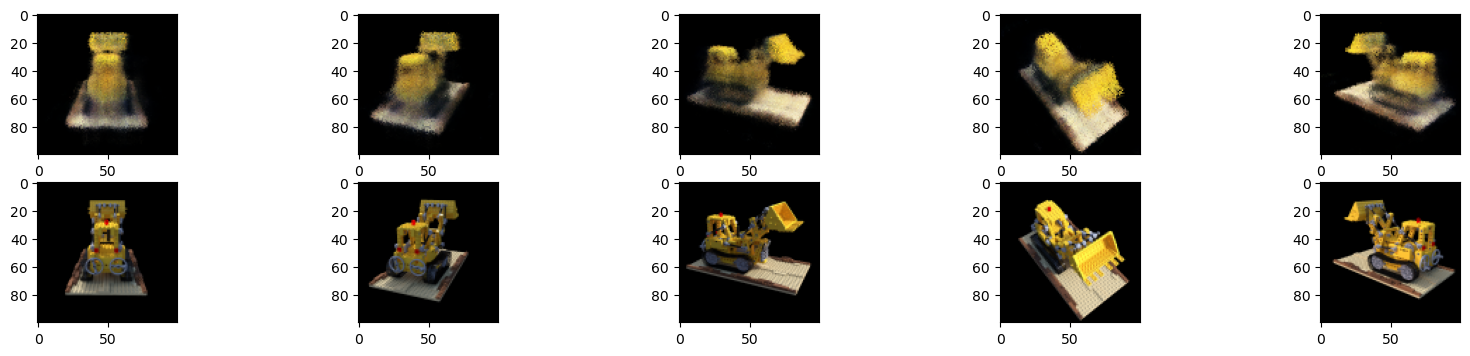

In [2]:
# Load the images
image_paths = [f'data_output_50_epochs/Reconstructed_{i}.png' for i in range(5)]
images = [cv2.imread(f'data_output_50_epochs/Reconstructed_{i}.png') for i in range(5)]

origin_paths = [f'data_output_50_epochs/Original_{i}.png' for i in range(5)]
origin_images = [cv2.imread(f'data_output_50_epochs/Original_{i}.png') for i in range(5)]

fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i,image in enumerate(images):
    axs[0,i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
for i,image in enumerate(origin_images):
    axs[1,i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## FFT Spectrum (Reconstructed Image)

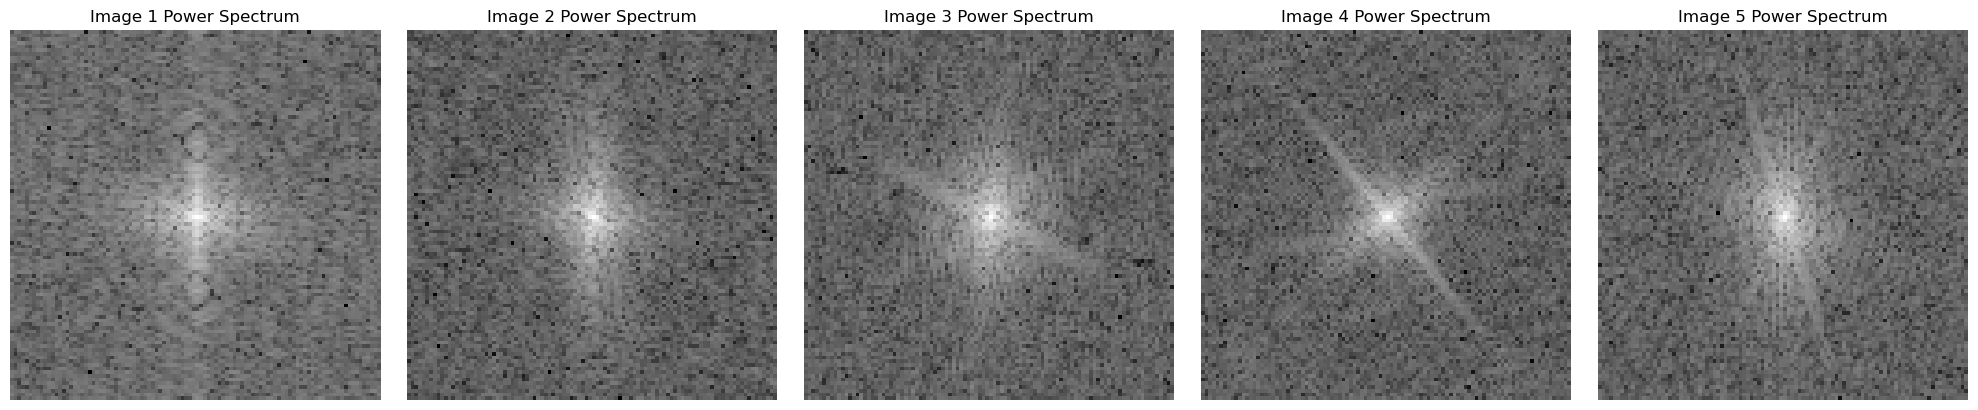

[{'mean': 28.306900000000002, 'std_dev': 51.44189258172759},
 {'mean': 28.6875, 'std_dev': 49.48539424668657},
 {'mean': 36.3968, 'std_dev': 62.39778641714785},
 {'mean': 50.9512, 'std_dev': 77.17536795221646},
 {'mean': 39.6881, 'std_dev': 61.599815084056864}]

In [3]:
# Load the images
image_paths = [f'data_output_50_epochs/Reconstructed_{i}.png' for i in range(5)]
images = [cv2.imread(f'data_output_50_epochs/Reconstructed_{i}.png', cv2.IMREAD_GRAYSCALE) for i in range(5)]

# Function to calculate the power spectrum of the noise
def power_spectrum(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

# Calculate the power spectrum for each image
power_spectra = [power_spectrum(img) for img in images]

# Plot the power spectra
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, spectrum in enumerate(power_spectra):
    axs[i].imshow(spectrum, cmap = 'gray')
    axs[i].set_title(f'Image {i+1} Power Spectrum')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Now let's calculate and print some statistics of the noise.
noise_statistics = []

for img in images:
    # Calculate the mean and standard deviation of the noise
    mean, std_dev = cv2.meanStdDev(img)
    noise_statistics.append({'mean': mean[0][0], 'std_dev': std_dev[0][0]})

noise_statistics

## Reconstructed Image's Flatten Distribution

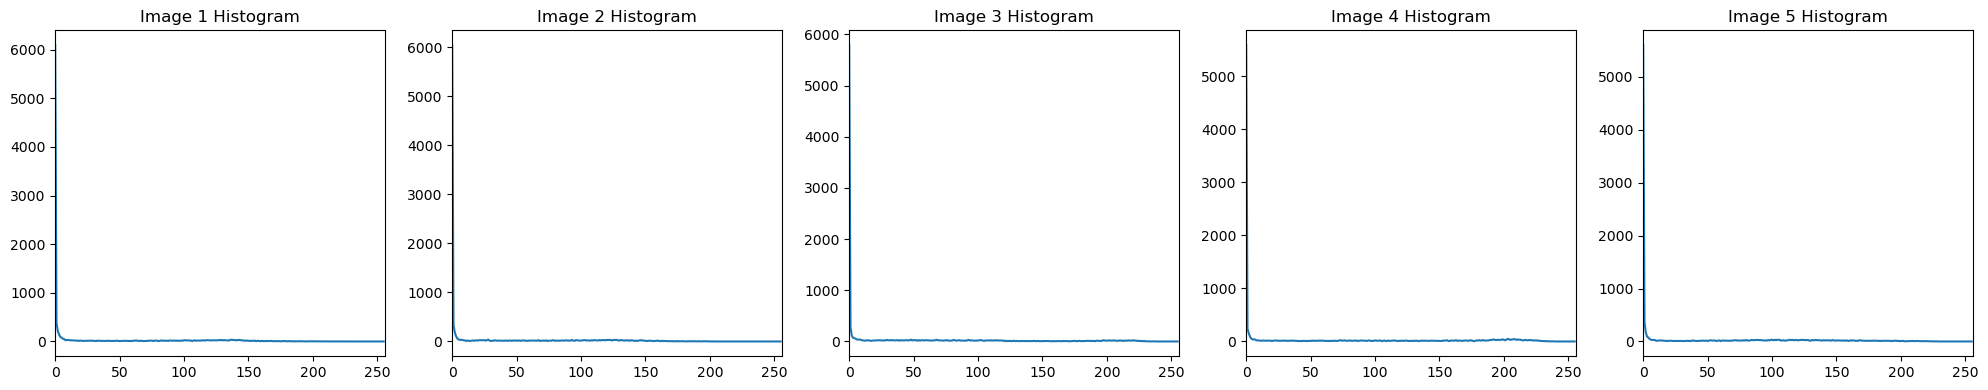

[(1.6374959593055838, 1.273983265550891),
 (1.5449150098433875, 1.0138379782530258),
 (1.7133690898587115, 1.765499196778121),
 (1.1563019633949236, -0.3088861054151444),
 (1.2923481988376393, 0.29894997770161025)]

In [4]:
from scipy.stats import skew, kurtosis

# Calculate additional statistics for each image: skewness and kurtosis
additional_statistics = []

for image in images:
    # Flatten the image to 1D array for statistical analysis
    image_flattened = image.flatten()
    # Calculate skewness and kurtosis
    image_skewness = skew(image_flattened)
    image_kurtosis = kurtosis(image_flattened)
    additional_statistics.append((image_skewness, image_kurtosis))

# Calculate the histograms of the images to observe the distribution of pixel intensities
histograms = []

for image in images:
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    histograms.append(hist)

# Plot the histograms
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.plot(histograms[i])
    ax.set_title(f'Image {i+1} Histogram')
    ax.set_xlim([0, 256])

plt.tight_layout()
plt.show()

# Output the additional noise statistics
additional_statistics

## Image Residual

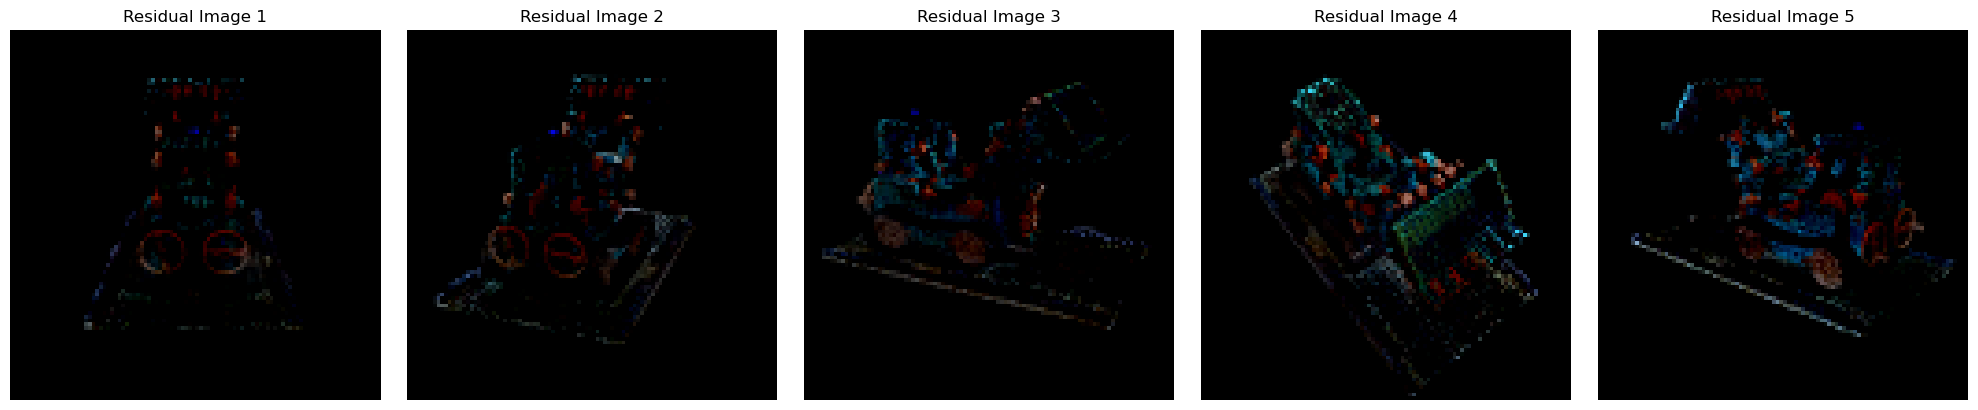

['data_output_50_epochs/Residual_0.png',
 'data_output_50_epochs/Residual_1.png',
 'data_output_50_epochs/Residual_2.png',
 'data_output_50_epochs/Residual_3.png',
 'data_output_50_epochs/Residual_4.png']

In [5]:
# Define a function to calculate the residual image by subtracting the reconstructed image from the original
def calculate_residual(original_path, reconstructed_path):
    # Read the original and reconstructed images
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    
    # Convert images to float for accurate subtraction
    original_float = original.astype(np.float32)
    reconstructed_float = reconstructed.astype(np.float32)
    
    # Calculate the residual
    residual = original_float - reconstructed_float
    
    # Clip values to the range [0, 255] and convert to uint8
    residual_clipped = np.clip(residual, 0, 255).astype(np.uint8)
    
    return residual_clipped

# Paths to the original images
original_paths = [f'data_output_50_epochs/Original_{i}.png' for i in range(5)]

# Calculate the residual for each pair of original and reconstructed images
residual_images = [calculate_residual(original_paths[i], image_paths[i]) for i in range(5)]

# Save the residual images and prepare their file paths for output
residual_paths = []
for i, residual in enumerate(residual_images):
    path = f'data_output_50_epochs/Residual_{i}.png'
    cv2.imwrite(path, residual)
    residual_paths.append(path)

# Plot the residual images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.imshow(residual_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Residual Image {i+1}')

plt.tight_layout()
plt.show()

# Output the file paths of the residual images
residual_paths

## Use Normal Distribution to Capture the Distribution Histogram

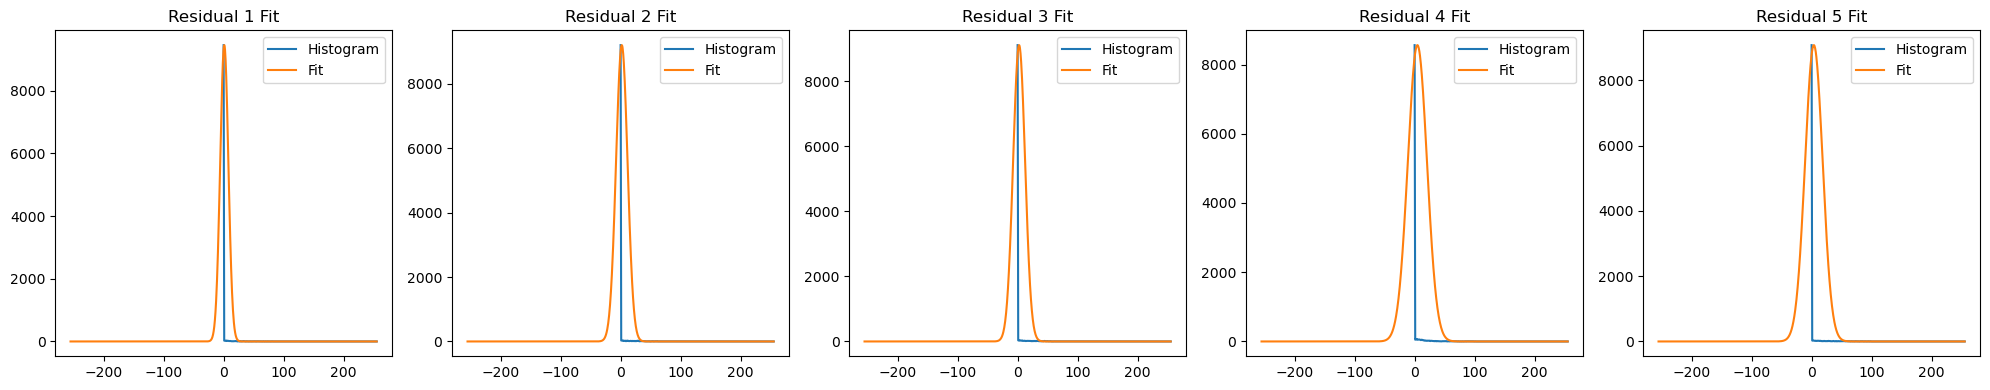

[(1.1151666666666666, 6.821654489361229),
 (1.9734666666666667, 9.584795041221392),
 (2.4787, 10.004003180893802),
 (4.629166666666666, 16.00125774136382),
 (3.7489333333333335, 14.65866861378921)]

In [6]:
# Function to analyze the distribution of the residuals
def analyze_residuals(residual_path):
    # Read the residual image
    residual = cv2.imread(residual_path, cv2.IMREAD_UNCHANGED)
    # Flatten the residual image to 1D array for statistical analysis
    residual_flattened = residual.flatten()
    # Calculate histogram of the residuals
    hist = cv2.calcHist([residual], [0], None, [256], [0, 256])
    return residual_flattened, hist

# Initialize lists to store analysis results
residual_data = []
histograms = []

# Analyze each residual image
for path in residual_paths:
    data, hist = analyze_residuals(path)
    residual_data.append(data)
    histograms.append(hist)

# Fit a normal distribution to the residuals
from scipy.stats import norm

# Parameters to store fitted distribution parameters
fitted_params = []

for data in residual_data:
    # Fit a normal distribution to the data
    mu, std = norm.fit(data)
    fitted_params.append((mu, std))

# Plot the histograms and the fitted distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

x = np.linspace(-255, 255, 1000)  # Range for plotting the fitted normal distributions

for i, ax in enumerate(axes):
    # Plot the histogram
    ax.plot(histograms[i], label='Histogram')
    # Plot the fitted distribution
    p = norm.pdf(x, fitted_params[i][0], fitted_params[i][1])
    ax.plot(x, p * np.max(histograms[i]) / np.max(p), label='Fit')  # Scale fitted line to histogram height
    ax.set_title(f'Residual {i+1} Fit')
    ax.legend()

plt.tight_layout()
plt.show()

# Output the fitted distribution parameters
fitted_params

## Frequency Spectrum of the Residual and GLCM

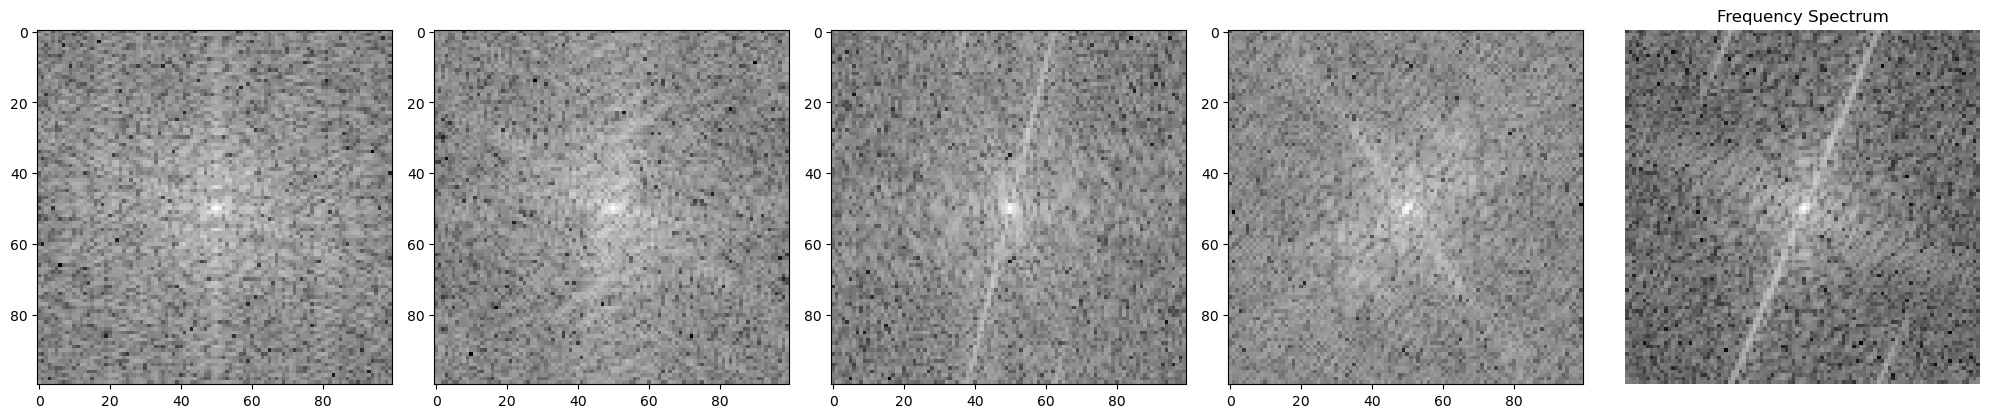

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,ASM
0,35.890909,1.254949,0.910793,0.898768,0.384793,0.807783
1,68.093535,2.044444,0.875755,0.861713,0.534927,0.742550
2,75.773333,2.430303,0.848863,0.830200,0.524240,0.689232
3,223.487071,5.024444,0.763856,0.744263,0.532524,0.553928
4,145.937576,3.474343,0.827688,0.810809,0.595795,0.657411


In [7]:
from skimage.feature import graycomatrix, graycoprops
from numpy.fft import fft2, fftshift

# Function to calculate the frequency spectrum of an image using Fourier Transform
def calculate_frequency_spectrum(image):
    f = fft2(image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))
    return magnitude_spectrum

# Function to calculate texture features using Grey Level Co-occurrence Matrix (GLCM)
def calculate_glcm_properties(image):
    # Compute GLCM on the image
    glcm = graycomatrix(image, distances=[1], angles=[0], symmetric=True, normed=True)
    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    return contrast, dissimilarity, homogeneity, energy, correlation, ASM

# Choose one of the residual images to analyze

residual_images = [cv2.imread(residual_image_path, cv2.IMREAD_GRAYSCALE) for residual_image_path in residual_paths]

# Calculate frequency spectrum
frequency_spectrum = [calculate_frequency_spectrum(residual_image) for residual_image in residual_images]

# Calculate GLCM properties
glcm_properties = [calculate_glcm_properties(residual_image) for residual_image in residual_images]


# Plot the histograms and the fitted distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
# Plot the frequency spectrum
for i, ax in enumerate(axes):
    # Plot the histogram
    ax.imshow(frequency_spectrum[i], cmap = "gray")

plt.title('Frequency Spectrum')
plt.axis('off')
plt.tight_layout()
plt.show()



# Output the GLCM properties
pd.DataFrame(glcm_properties,columns = ["Contrast","Dissimilarity","Homogeneity","Energy","Correlation","ASM"])

## Statistics of Residual Frequency Spectrum

In [8]:
# Calculate statistical measures of the frequency spectra
spectra_stats = []
for spectrum in frequency_spectrum:
    mean = np.mean(spectrum)
    std = np.std(spectrum)
    max_val = np.max(spectrum)
    min_val = np.min(spectrum)
    spectra_stats.append({'mean': mean, 'std': std, 'max': max_val, 'min': min_val})

pd.DataFrame(spectra_stats)

,mean,std,max,min
0,5.833404,0.723451,9.160099,1.581786
1,6.224428,0.761313,9.799515,1.662371
2,6.251892,0.750144,10.075927,1.824602
3,6.761684,0.737745,10.784234,1.619909
4,6.535673,0.791320,10.516915,3.145104


## GLCM for Different Angles

In [9]:
# Function to calculate GLCM properties for all four angles (0, 45, 90, 135 degrees)
def calculate_glcm_properties_all_angles(image):
    # Compute GLCM on the image for four angles
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles in radians: 0, 45, 90, 135 degrees
    glcm = graycomatrix(image, distances=[1], angles=angles, symmetric=True, normed=True)
    # Compute GLCM properties for each angle
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    glcm_properties = {prop: [graycoprops(glcm, prop)[0, i] for i in range(4)] for prop in properties}
    return glcm_properties

# Calculate GLCM properties for all angles for each residual image
glcm_properties_all_images = [calculate_glcm_properties_all_angles(cv2.imread(path, cv2.IMREAD_GRAYSCALE)) for path in residual_paths]

pd.DataFrame(glcm_properties_all_images)

,contrast,dissimilarity,homogeneity,energy,correlation,ASM
0,"[35.89090909090888, 44.78053259871406, 33.1931...","[1.2549494949494853, 1.4576063666972647, 1.198...","[0.9107930810326812, 0.9027333420595421, 0.913...","[0.8987676124003869, 0.8900149194973639, 0.900...","[0.38479254621390896, 0.23984811847654297, 0.4...","[0.8077832210998922, 0.7921265569278991, 0.810..."
1,"[68.09353535353453, 102.90337720640646, 85.422...","[2.0444444444444247, 2.6164677073767724, 2.207...","[0.875754642991847, 0.8605472290654294, 0.8756...","[0.861713134145363, 0.8475990582560269, 0.8598...","[0.5349269145220279, 0.3038884562111956, 0.416...","[0.7425495255586244, 0.7184241635565036, 0.739..."
2,"[75.77333333333266, 105.50943781246647, 92.701...","[2.43030303030301, 3.1111111111110654, 2.86646...","[0.8488633872166725, 0.8305042977329434, 0.836...","[0.8301998356821279, 0.8153570079201149, 0.818...","[0.5242401846821154, 0.3436803715385115, 0.417...","[0.689231767166632, 0.6648070503644423, 0.6704..."
3,"[223.4870707070661, 240.15284154677306, 235.92...","[5.0244444444443435, 5.032547699214227, 4.9175...","[0.7638555670936281, 0.76799939929149, 0.77142...","[0.7442631078570204, 0.7469513380686855, 0.750...","[0.5325236056833552, 0.5021867842630815, 0.506...","[0.5539275737169909, 0.5579363014425998, 0.562..."
4,"[145.93757575757323, 195.89511274359322, 191.7...","[3.4743434343433752, 4.248137945107548, 4.1157...","[0.8276876796410376, 0.8131456889239049, 0.821...","[0.8108091063865172, 0.7970887783418521, 0.804...","[0.5957945329460721, 0.4624334719367173, 0.468...","[0.6574114069993025, 0.6353505205585062, 0.647..."


- Enhanced Autocorrelation Analysis:

Extend the autocorrelation analysis to capture directional anisotropies.
Perform a radial average around the center peak to understand if the noise is isotropic or has preferred directions.
Fit an anisotropic 2D Gaussian to the autocorrelation to model the noise distribution with directional parameters.
- Frequency Domain Analysis:

Use 2D Fourier analysis to capture dominant frequencies and directions in the noise.
Identify and isolate systematic patterns or repetitive artifacts within the frequency spectrum.
- Texture Analysis:

Extend GLCM analysis to multiple orientations and distances to capture the spatial relationship between pixels in more detail.
Calculate Haralick texture features to quantify the textural information of the noise.
- Higher-Order Statistics:

Use kurtosis and skewness maps to visualize and quantify the non-Gaussian aspects of the noise distribution across the image.
Explore other statistical measures like entropy and joint probability distributions.
- Spatial Filtering:

Experiment with different spatial filters (e.g., Wiener, anisotropic diffusion) to model the noise removal process and use the filtered residuals to gain insights into the noise characteristics.
- Model Fitting:

Fit parametric models (e.g., Gaussian Mixture Models) to the residuals to capture different noise components.
Use non-parametric models (e.g., Kernel Density Estimation) to model the noise distribution without assuming any predefined shape.
- Validation:

Apply the modeled noise distribution to simulated data to see if the reconstruction improves.
Iterate the process using residuals from these improved reconstructions to refine the noise model.

## Auto Correlation

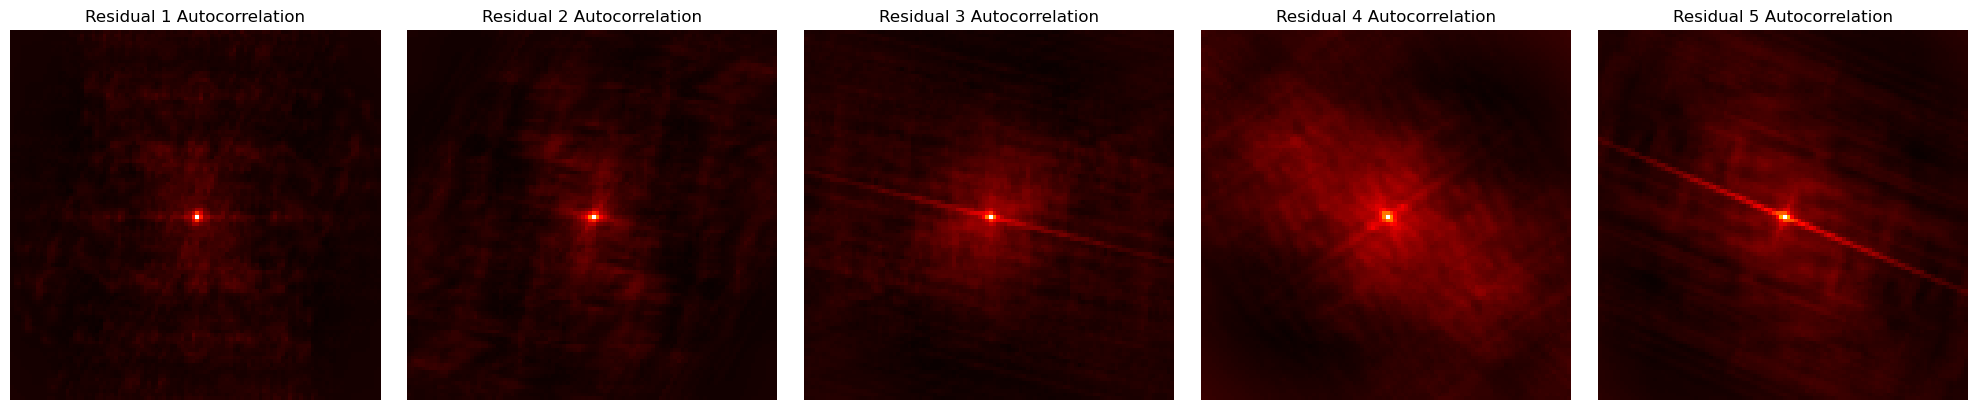

In [10]:
from scipy.signal import correlate2d

# Function to calculate 2D autocorrelation of an image
def calculate_autocorrelation(image):
    # Normalize image
    image_normalized = image - np.mean(image)
    # Calculate autocorrelation using correlate2d
    autocorr = correlate2d(image_normalized, image_normalized, mode='full')
    # Normalize autocorrelation by the maximum value to bring the values between [0, 1]
    autocorr_normalized = autocorr / np.max(autocorr)
    return autocorr_normalized

# Calculate 2D autocorrelation for each residual image
autocorrelations = [calculate_autocorrelation(cv2.imread(path, cv2.IMREAD_GRAYSCALE)) for path in residual_paths]

# Plot the 2D autocorrelation for each residual image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    # Select the central part of the autocorrelation for display
    center = tuple(map(lambda x: x // 2, autocorrelations[i].shape))
    extent = 50  # We will display a 50x50 region around the center
    autocorr_display = autocorrelations[i][
        center[0]-extent:center[0]+extent, 
        center[1]-extent:center[1]+extent
    ]
    ax.imshow(autocorr_display, cmap='hot')
    ax.axis('off')
    ax.set_title(f'Residual {i+1} Autocorrelation')

plt.tight_layout()
plt.show()


## Gaussian Mixture

There's no spatial information in the GMM

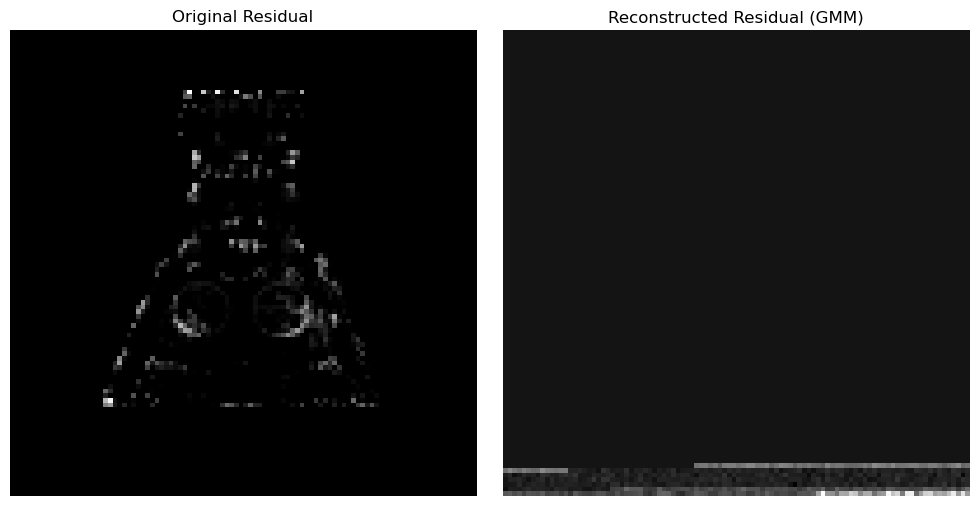

In [11]:
from sklearn.mixture import GaussianMixture

# Function to fit a GMM to the residual image and sample from it to reconstruct the residual
def gmm_reconstruct_residual(residual_image, n_components=5):
    # Flatten the residual image to 1D array for GMM
    residual_flattened = residual_image.flatten().reshape(-1, 1)
    
    # Fit a Gaussian mixture model to the flattened data
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(residual_flattened)
    
    # Sample from the GMM to generate new data
    sampled_data = gmm.sample(residual_image.size)[0]
    
    # Reshape the sampled data back to the original image shape
    reconstructed_residual = sampled_data.reshape(residual_image.shape)
    
    return reconstructed_residual

# Load one of the residual images to reconstruct using GMM
residual_image = cv2.imread(residual_paths[0], cv2.IMREAD_GRAYSCALE)

# Reconstruct the residual image using GMM
reconstructed_residual_gmm = gmm_reconstruct_residual(residual_image, n_components=5)

# Display the original and reconstructed residuals
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(residual_image, cmap='gray')
ax[0].set_title('Original Residual')
ax[0].axis('off')
ax[1].imshow(reconstructed_residual_gmm, cmap='gray')
ax[1].set_title('Reconstructed Residual (GMM)')
ax[1].axis('off')
plt.tight_layout()
plt.show()


## Spatial- Aware Gaussian Mixture

In [12]:
residual_image = cv2.imread(residual_paths[0], cv2.IMREAD_GRAYSCALE)

In [13]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

def spatially_constrained_gmm(image, n_components=5):
    # Prepare the features with spatial information
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    spatial_features = np.dstack((x, y, image)).reshape(-1, 3)
    
    # Initialize GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    
    # Custom EM algorithm
    max_iterations = 100
    for iteration in range(max_iterations):
        # E-step: calculate responsibilities considering spatial information
        # ... (custom code)
        responsibilities = np.zeros((spatial_features.shape[0], n_components))

        for i in range(n_components):
            # Calculate the probability of each point belonging to the Gaussian component
            # This would be the normal distribution probability considering the spatial information
            responsibilities[:, i] = mvn.pdf(spatial_features, mean=gmm.means_[i], cov=gmm.covariances_[i])

        # Normalize the responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        # M-step: update means, covariances, and mixing coefficients
        # ... (custom code)
        for i in range(n_components):
            # Calculate the total responsibility assigned to this component
            total_responsibility = responsibilities[:, i].sum()
    
            # Update means with spatial information
            gmm.means_[i] = np.average(spatial_features, axis=0, weights=responsibilities[:, i])
    
            # Update covariances with spatial information
            diff = spatial_features - gmm.means_[i]
            gmm.covariances_[i] = np.dot(responsibilities[:, i] * diff.T, diff) / total_responsibility
    
            # Update mixing coefficients
            gmm.weights_[i] = total_responsibility / spatial_features.shape[0]

        
        # Regularization to ensure spatial consistency
        # ... (custom code)
        # The regularization term could be a function of the difference between neighboring pixels
        def regularization_term(image):
            # This could be a gradient or Laplacian or other edge-detection operator
            # that penalizes differences between adjacent pixels
            grad = np.gradient(image)
            return np.sum(grad[0] ** 2 + grad[1] ** 2)

        # Apply the regularization during the M-step, affecting the covariances
        for i in range(n_components):
            reg_term = regularization_term(gmm.means_[i].reshape(height, width))
            gmm.covariances_[i] += reg_lambda * reg_term
    
    # Sample from the GMM to generate new data
    # ... (custom code)
    sampled_data = np.zeros(spatial_features.shape)

    for i in range(n_components):
        # Sample from the current Gaussian distribution
        sampled_data += responsibilities[:, [i]] * np.random.multivariate_normal(
        gmm.means_[i], gmm.covariances_[i], size=spatial_features.shape[0])

    
    # Reshape the sampled data back to the original image shape
    # ... (custom code)
    # Reshape the sampled data back to the original image shape
    reconstructed_residual = sampled_data[:, 2].reshape(height, width)

    return reconstructed_image


# Apply the spatially constrained GMM
reconstructed_image = spatially_constrained_gmm(residual_image)

AttributeError: 'GaussianMixture' object has no attribute 'means_'

In [ ]:
def spatially_constrained_gmm(image, n_components=5):
    # Prepare the features with spatial information
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    spatial_features = np.dstack((x, y, image)).reshape(-1, 3)
    
    # Initialize GMM parameters
    n_samples = spatial_features.shape[0]
    random_indices = np.random.choice(n_samples, n_components)
    means = spatial_features[random_indices]
    covariances = np.array([np.eye(3) for _ in range(n_components)])
    weights = np.full(n_components, 1 / n_components)
    
    # Custom EM algorithm
    max_iterations = 10  # Reduced the number of iterations for simplicity
    for iteration in range(max_iterations):
        # E-step: calculate responsibilities
        # ...
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            rv = mvn(means[i], covariances[i], allow_singular=True)
            responsibilities[:, i] = rv.pdf(spatial_features) * weights[i]
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        # M-step: update means, covariances, and mixing coefficients
        # ...
        for i in range(n_components):
            weight_i = responsibilities[:, i].sum()
            means[i] = np.sum(responsibilities[:, i, np.newaxis] * spatial_features, axis=0) / weight_i
            diff = spatial_features - means[i]
            covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / weight_i
            weights[i] = weight_i / n_samples
    
    # Sample from the GMM to generate new data
    # ...
    reconstructed_residual = np.zeros((height, width))
    for i in range(n_components):
        n_samples_component = int(weights[i] * n_samples)
        samples = mvn.rvs(means[i], covariances[i], size=n_samples_component)
        reconstructed_residual += samples[:, 2].reshape(height, width)
    reconstructed_residual /= reconstructed_residual.max()  # Normalize to [0, 1] for display purposes
    
    return reconstructed_residual

reconstructed_image = spatially_constrained_gmm(residual_image)